# 전처리

한번에 실행해도 괜찮음 아마 10분정도 걸릴듯

**Import**

In [ ]:
import os
import re
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from bs4 import BeautifulSoup
import pandas as pd
from difflib import SequenceMatcher
from soupsieve import SelectorSyntaxError

**Google Drive 마운트 및 JSON 파일 로드**

In [ ]:
# Google Drive 마운트 (Colab 환경 사용 시 필요)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    pass  # Colab 외 환경에서는 무시

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 경로 설정
train_folder_path = '/content/drive/MyDrive/파란학기_TRAIN_data'
test_folder_path = '/content/drive/MyDrive/파란학기_TEST_data'

번호는 무시하고 리스트에 순서대로 저장(중복 문제 발생 안함)

In [ ]:
# 데이터를 리스트에 순차적으로 추가하는 방식
def load_json_files(folder_path):
    merged_data = []  # 리스트를 사용하여 데이터를 병합

    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            json_file_path = os.path.join(folder_path, filename)
            with open(json_file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                # JSON 파일의 모든 값을 리스트에 추가
                merged_data.extend(data.values())

    return merged_data


In [ ]:
# 학습 데이터와 테스트 데이터 로드
merged_train_data = load_json_files(train_folder_path)
merged_test_data = load_json_files(test_folder_path)

In [ ]:
# # 모든 JSON 데이터를 하나로 합치기
# merged_data = {}
# for data in data_list:
#     merged_data.update(data)

In [ ]:
# JSON 파일 로드
# import json
# with open(json_file_path, 'r', encoding='utf-8') as f:
#      data = json.load(f)

**HTML에서 텍스트 추출하는 함수**

In [ ]:
# HTML에서 텍스트 추출과 불필요한 공백 제거
def extract_text_from_html(html_code):
    if not isinstance(html_code, str):
        html_code = str(html_code)
    html_code = re.sub(r'<script.*?>.*?</script>', '', html_code, flags=re.DOTALL)
    html_code = re.sub(r'<style.*?>.*?</style>', '', html_code, flags=re.DOTALL)
    html_code = re.sub(r'<!--.*?-->', '', html_code, flags=re.DOTALL)
    text = re.sub('<[^<]+?>', '', html_code)
    return re.sub(r'\s+', ' ', text).strip()

In [ ]:
# # 텍스트를 일정 길이로 나누기
# def split_text(text, max_length=512):
#     words = text.split()
#     chunks = []
#     chunk = ""

#     for word in words:
#         if len(chunk) + len(word) + 1 <= max_length:
#             chunk += (" " + word if chunk else word)
#         else:
#             chunks.append(chunk)
#             chunk = word
#     if chunk:
#         chunks.append(chunk)

#     return chunks

**CSS 문자열을 딕셔너리로 변환하는 함수 정의**

In [ ]:
def css_to_dict(css_string):
    css_dict = {}
    pattern = re.compile(r'([^{]+)\s*\{\s*([^}]+)\s*\}')
    matches = pattern.findall(css_string)
    for selector, properties in matches:
        selector = selector.strip()
        properties_dict = {}
        for prop_value in properties.split(';'):
            if prop_value.strip():
                parts = prop_value.split(":", 1)
                if len(parts) == 2:
                    prop, value = parts
                    properties_dict[prop.strip()] = value.strip()
        css_dict[selector] = properties_dict
    return css_dict

특정 데이터의 변환 (문자열에서 딕셔너리로)결과 확인하기 <- 굳이 안돌려봐도 되긴함

In [ ]:
# 예시로 특정 인덱스의 데이터를 확인 (예: 500번 인덱스 데이터)
index_to_check = 500  # 확인할 인덱스 번호 (리스트 기반)
if index_to_check < len(merged_train_data):  # 인덱스가 유효한지 확인
    css_styles = merged_train_data[index_to_check].get('CSS', '')
    if css_styles:
        css_dict = css_to_dict(css_styles) if isinstance(css_styles, str) else {}
        print("변환된 CSS 딕셔너리:", css_dict)
    else:
        print(f"{index_to_check}번 데이터에 대한 CSS를 찾을 수 없습니다.")
else:
    print(f"{index_to_check}번 인덱스가 데이터 범위를 벗어났습니다.")

변환된 CSS 딕셔너리: {'.a8jt5op.atm_3f_idpfg4.atm_7h_hxbz6r.atm_7i_ysn8ba.atm_e2_t94yts.atm_ks_zryt35.atm_l8_idpfg4.atm_mk_stnw88.atm_vv_1q9ccgz.atm_vy_t94yts.dir.dir-ltr': {'-webkit-border-horizontal-spacing': '0px', '-webkit-border-image': 'none', '-webkit-border-vertical-spacing': '0px', '-webkit-box-align': 'stretch', '-webkit-box-decoration-break': 'slice', '-webkit-box-direction': 'normal', '-webkit-box-flex': '0', '-webkit-box-ordinal-group': '1', '-webkit-box-orient': 'horizontal', '-webkit-box-pack': 'start', '-webkit-box-reflect': 'none', '-webkit-font-smoothing': 'antialiased', '-webkit-line-break': 'strict', '-webkit-line-clamp': 'none', '-webkit-locale': '"ko"', '-webkit-mask-box-image': 'none', '-webkit-mask-box-image-outset': '0', '-webkit-mask-box-image-repeat': 'stretch', '-webkit-mask-box-image-slice': '0 fill', '-webkit-mask-box-image-source': 'none', '-webkit-mask-box-image-width': 'auto', '-webkit-print-color-adjust': 'economy', '-webkit-rtl-ordering': 'logical', '-webkit

 HTML에 CSS 스타일을 적용하는 함수

In [ ]:
# CSS와 HTML 적용 함수
def apply_css_to_dom(html_content, css_styles):
    soup = BeautifulSoup(html_content, 'html.parser')
    css_dict = css_to_dict(css_styles) if isinstance(css_styles, str) else {}
    for selector, styles in css_dict.items():
        try:
            elements = soup.select(selector)
        except Exception as e:
            print(f"잘못된 선택자 무시됨: {selector} - {e}")
            continue
        for element in elements:
            if 'style' not in element.attrs:
                element.attrs['style'] = ""
            for prop, value in styles.items():
                element.attrs['style'] += f"{prop}: {value}; "
    return str(soup)

HTML과 CSS 매핑 잘됐는지 결과 확인하는 함수 정의 <- 굳이 안돌려봐도 되긴함

In [ ]:
# 특정 인덱스에서 CSS 적용 후 HTML 콘텐츠 반환
def apply_css_and_display_html(data, index):
    if index < 0 or index >= len(data):
        print(f"인덱스 {index}가 데이터 범위를 벗어났습니다.")
        return
    item = data[index]  # 리스트에서 특정 인덱스의 항목을 가져옴
    html_content = item.get('HTML')
    css_styles = item.get('CSS')
    result_html = apply_css_to_dom(html_content, css_styles)
    print("CSS가 적용된 HTML 콘텐츠:")
    print(result_html)


특정 데이터의 매핑 결과 확인하기 <- 굳이 안돌려봐도 되긴함

In [ ]:
# 특정 인덱스(예: '10')의 결과 확인
apply_css_and_display_html(merged_train_data, 10)

CSS가 적용된 HTML 콘텐츠:
<div aria-label="12 of 54" aria-roledescription="slide" class="swiper-slide slide-12" data-swiper-slide-index="11" data-v-4b520e00="" role="group" style='width: 550px; margin-right: 40px;-webkit-border-horizontal-spacing: 0px; -webkit-border-image: none; -webkit-border-vertical-spacing: 0px; -webkit-box-align: stretch; -webkit-box-decoration-break: slice; -webkit-box-direction: normal; -webkit-box-flex: 0; -webkit-box-ordinal-group: 1; -webkit-box-orient: horizontal; -webkit-box-pack: start; -webkit-box-reflect: none; -webkit-font-smoothing: auto; -webkit-line-break: auto; -webkit-line-clamp: none; -webkit-locale: "ko"; -webkit-mask-box-image: none; -webkit-mask-box-image-outset: 0; -webkit-mask-box-image-repeat: stretch; -webkit-mask-box-image-slice: 0 fill; -webkit-mask-box-image-source: none; -webkit-mask-box-image-width: auto; -webkit-print-color-adjust: economy; -webkit-rtl-ordering: logical; -webkit-tap-highlight-color: rgba(0, 0, 0, 0.18); -webkit-text-combine

**문자열 간의 유사도 계산하는 함수**

In [ ]:
# 문자열 유사도 계산 함수
def calculate_similarity(str1, str2):
    similarity_ratio = SequenceMatcher(None, str1, str2).ratio()
    return similarity_ratio  # 0과 1 사이의 값 반환

HTML과 Static_HTML 일치도를 계산하여 가장 높은 일치율 반환하는 함수(없으면 0%으로 설정)

In [ ]:
def find_best_static_html_match(html_content, static_html_list):
    if not static_html_list:
        return 0
    if isinstance(static_html_list, str):
        return SequenceMatcher(None, html_content, static_html_list).ratio()
    elif isinstance(static_html_list, list):
        return max(SequenceMatcher(None, html_content, static_html).ratio() for static_html in static_html_list)
    else:
        return 0

**데이터 중복 제거 후 전처리하는 함수**

In [ ]:
def process_data(data):
    unique_data = []
    seen = set()

    # 중복 제거 (HTML을 기준으로)
    for item in data:
        html_content = item.get('HTML', '')
        if html_content not in seen:
            seen.add(html_content)
            unique_data.append(item)

    processed_texts = []
    preprocessed_htmls = []
    similarity_scores = []
    labels = []
    types = []

    for item in unique_data:
        html_content = item.get('HTML', '')
        css_styles = item.get('CSS', '')
        html_with_css = apply_css_to_dom(html_content, css_styles)
        extracted_text = extract_text_from_html(html_with_css)

        static_html = item.get('Static_HTML', [])
        similarity = find_best_static_html_match(html_with_css, static_html)
        similarity_scores.append(similarity)

        preprocessed_htmls.append(html_with_css)
        processed_texts.append(extracted_text)
        labels.append(item.get('다크패턴 여부', ''))
        types.append(item.get('type', ''))

    df = pd.DataFrame({
        '다크패턴 여부': labels,
        'type': types,
        '추출한 텍스트': processed_texts,
        'HTML+CSS': preprocessed_htmls,
        'Static HTML 일치도': similarity_scores
    })

    return df


In [ ]:
# def remove_duplicates_from_dataframe(df, subset=None, keep='first', sort_by=None):
#     if sort_by:
#         df = df.sort_values(by=sort_by).reset_index(drop=True)
#     return df.drop_duplicates(subset=subset, keep=keep).reset_index(drop=True)

학습데이터 전처리

In [ ]:
# 학습 데이터 전처리
df_train = process_data(merged_train_data)
print("학습 데이터 전처리 완료")

잘못된 선택자 무시됨: .absolute.z-10.top-0.text-white.w-full.h-full.flex.flex-col.p-6.justify-end.drop-shadow-[1px_1px_1px_rgba(0,0,0,0.12)] - Malformed attribute selector at position 88
  line 1:
.absolute.z-10.top-0.text-white.w-full.h-full.flex.flex-col.p-6.justify-end.drop-shadow-[1px_1px_1px_rgba(0,0,0,0.12)]
                                                                                        ^
잘못된 선택자 무시됨: .text-[18px].leading-[24px].mt-4 - Malformed attribute selector at position 6
  line 1:
.text-[18px].leading-[24px].mt-4
      ^
잘못된 선택자 무시됨: .text-[32px].leading-[40px].font-bold - Malformed attribute selector at position 6
  line 1:
.text-[32px].leading-[40px].font-bold
      ^
잘못된 선택자 무시됨: .flex.items-center.[&>*:not(:last-child)]:mr-1.5 - Malformed class selector at position 18
  line 1:
.flex.items-center.[&>*:not(:last-child)]:mr-1.5
                  ^
잘못된 선택자 무시됨: .font-semibold.space-s-2.mt-0.5.text-heading.lg:text-lg.lg:mt-1.5 - Malformed class selector at position 29
  lin

테스트 데이터 전처리

In [ ]:
# 테스트 데이터 전처리
df_test = process_data(merged_test_data)
print("테스트 데이터 전처리 완료")

테스트 데이터 전처리 완료


In [ ]:
# # JSON에서 중복 제거 및 데이터 전처리
# unique_data = []
# seen = set()
# for item in merged_data.values():
#     html_content = item.get('HTML')
#     if html_content not in seen:
#         seen.add(html_content)
#         unique_data.append(item)

텍스트 벡터화

In [ ]:
def vectorize_text(data):
    vectorizer = TfidfVectorizer(max_features=1000)
    vectors = vectorizer.fit_transform(data)
    return vectors

T-SNE 시각화 함수

In [ ]:
def plot_tsne(vectors, df):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(vectors.toarray())
    color_map = {
        'X': 'blue',
        'O': {
            '압박형': 'red',
            '방해형': 'green',
            '오도형': 'orange'
        }
    }
    colors = []
    for _, row in df.iterrows():
        if row['다크패턴 여부'] == 'X':
            colors.append(color_map['X'])
        else:
            colors.append(color_map['O'].get(row['type'], 'gray'))
    plt.figure(figsize=(10, 7))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=colors, alpha=0.7, s=50)
    plt.title('t-SNE Visualization of Text Vectors')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

PCA 시각화 함수

In [ ]:
def plot_pca_3d(vectors, df):
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(vectors.toarray())
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    color_map = {
        'X': 'blue',
        'O': {
            '압박형': 'red',
            '방해형': 'green',
            '오도형': 'orange'
        }
    }
    colors = []
    for _, row in df.iterrows():
        if row['다크패턴 여부'] == 'X':
            colors.append(color_map['X'])
        else:
            colors.append(color_map['O'][row['type']])
    ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=colors, marker='o')
    ax.set_xlabel('Primary Keyword')
    ax.set_ylabel('Display Style')
    ax.set_zlabel('Darkpattern Type')
    plt.show()

train 시각화 실행

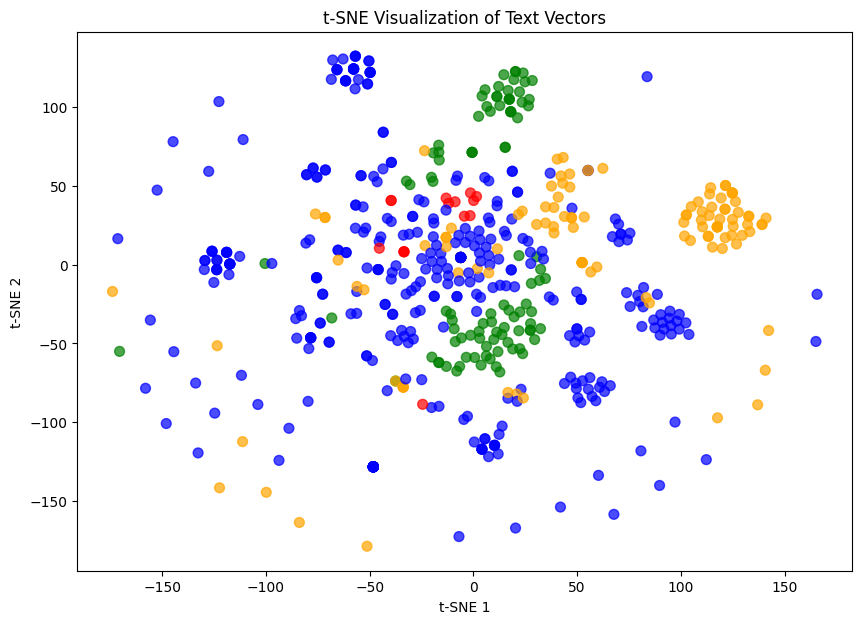

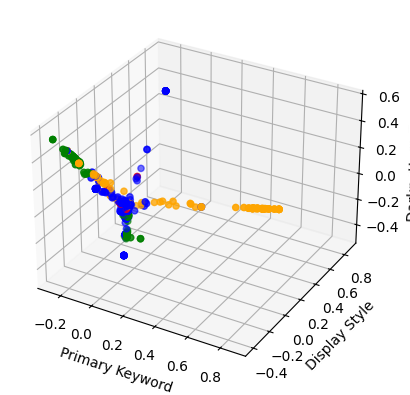

In [ ]:
# 시각화 실행
vectors_train = vectorize_text(df_train['추출한 텍스트'].tolist())
plot_tsne(vectors_train, df_train)
plot_pca_3d(vectors_train, df_train)

test 시각화 실행

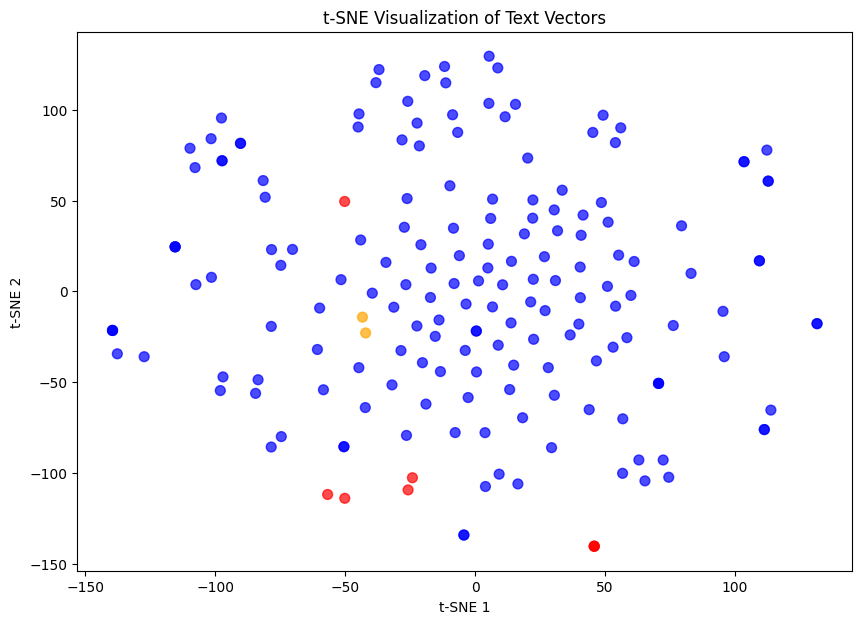

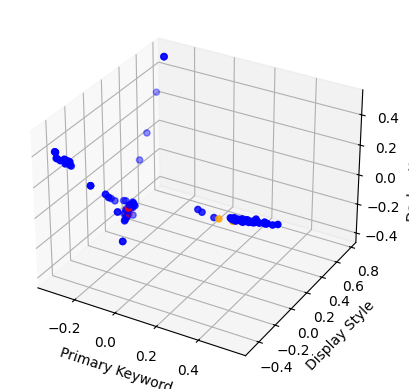

In [ ]:
vectors_test = vectorize_text(df_test['추출한 텍스트'].tolist())
plot_tsne(vectors_test, df_test)
plot_pca_3d(vectors_test, df_test)

각 데이터 개수 확인

In [ ]:
# 다크패턴 여부 데이터 개수 확인
x_count_train = df_train[df_train['다크패턴 여부'] == 'X'].shape[0]
o_count_train = df_train[df_train['다크패턴 여부'] == 'O'].shape[0]
print(f"학습 데이터 - 다크패턴 여부가 'X'인 데이터의 수: {x_count_train}")
print(f"학습 데이터 - 다크패턴 여부가 'O'인 데이터의 수: {o_count_train}")

학습 데이터 - 다크패턴 여부가 'X'인 데이터의 수: 367
학습 데이터 - 다크패턴 여부가 'O'인 데이터의 수: 239


In [ ]:
# 다크패턴 여부가 'O'인 데이터 중 type별 개수 확인
o_data_train = df_train[df_train['다크패턴 여부'] == 'O']
압박형_count_train = o_data_train[o_data_train['type'] == '압박형'].shape[0]
방해형_count_train = o_data_train[o_data_train['type'] == '방해형'].shape[0]
오도형_count_train = o_data_train[o_data_train['type'] == '오도형'].shape[0]

In [ ]:
print(f"학습 데이터 - 압박형 데이터의 수: {압박형_count_train}")
print(f"학습 데이터 - 방해형 데이터의 수: {방해형_count_train}")
print(f"학습 데이터 - 오도형 데이터의 수: {오도형_count_train}")

학습 데이터 - 압박형 데이터의 수: 15
학습 데이터 - 방해형 데이터의 수: 99
학습 데이터 - 오도형 데이터의 수: 125


잘못된 선택자 무시됨 -> CSS 선택자 구문 중 일부가 BeautifulSoup의 select() 메서드에서 지원되지 않기 때문에 발생함.  일부 복잡하거나 특정 CSS 규칙(예: 속성 선택자 [&>*:not(:last-child)] 또는 특수 문자와 관련된 선택자 등)은 구문 분석 중에 오류 발생

In [ ]:
# # 중복 제거된 데이터를 process_html_contents에 전달
# df_no_duplicates = process_html_contents_with_similarity(unique_data)
# print("최종 DataFrame:")
# print(df_no_duplicates)

In [ ]:
# # 텍스트 벡터화 및 시각화
# vectors = vectorize_text(df_no_duplicates['추출한 텍스트'].tolist())

In [ ]:
# # 시각화 함수 호출
# plot_pca_3d(vectors, df_no_duplicates)

In [ ]:
# plot_tsne(vectors, df_no_duplicates)

In [ ]:
# 데이터 프레임 생성
df = pd.DataFrame(df_train)

# 데이터 프레임 출력
print("생성된 데이터프레임:")
print(df)

생성된 데이터프레임:
    다크패턴 여부 type                                            추출한 텍스트  \
0         X       쿠팡 랭킹순은 판매 실적, 고객 선호도, 상품 경쟁력 및검색 정확도 등을 종합적으로...   
1         X       네일팁/페디팁/스티커 일반네일 젤네일 케어/영양/리무버 네일케어도구 네일아트소품/도...   
2         X       총 수량 16개 이하 16~32개 32~50개 50~100개 100~200개 200...   
3         X       무료배송 (한정)빙그레 바나나 우유 미니 120ml x 24개 코스트코 바나나맛 음...   
4         X       쿠팡플레이 로켓배송 로켓프레시 쿠팡비즈 로켓직구 골드박스 판매자특가 와우회원할인 이...   
..      ...  ...                                                ...   
601       X                             Download the AliExpress app   
602       X       RecommendedToolsPhones &amp; Telecommunication...   
603       X       RecommendedToolsPhones &amp; Telecommunication...   
604       X       XIAOMI Wireless Bluetooth Headphones In Ear St...   
605       X       Original Wireless Bluetooth Earphone Transpare...   

                                              HTML+CSS  Static HTML 일치도  
0    <div id="help-coupang-ranking-search-sort"><sp...       

In [ ]:
from IPython.display import display

# 데이터프레임 예쁘게 출력
display(df)


,다크패턴 여부,type,추출한 텍스트,HTML+CSS,Static HTML 일치도
0,X,,"쿠팡 랭킹순은 판매 실적, 고객 선호도, 상품 경쟁력 및검색 정확도 등을 종합적으로...","<div id=""help-coupang-ranking-search-sort""><sp...",0
1,X,,네일팁/페디팁/스티커 일반네일 젤네일 케어/영양/리무버 네일케어도구 네일아트소품/도...,"<div class=""third-depth-list"" style='-webkit-b...",0
2,X,,총 수량 16개 이하 16~32개 32~50개 50~100개 100~200개 200...,"<div class=""search-filter-options search-attr_...",0
3,X,,무료배송 (한정)빙그레 바나나 우유 미니 120ml x 24개 코스트코 바나나맛 음...,"<div class=""descriptions-inner"" style='-webkit...",0
4,X,,쿠팡플레이 로켓배송 로켓프레시 쿠팡비즈 로켓직구 골드박스 판매자특가 와우회원할인 이...,"<div class=""gnb-menu-container"" id=""gnb-menu-c...",0
...,...,...,...,...,...
601,X,,Download the AliExpress app,"<div class=""down-load-app--text--3b5oaiF"" styl...",0
602,X,,RecommendedToolsPhones &amp; Telecommunication...,"<div class=""rax-view-v2 tab_pc_box"" id="""" styl...",0
603,X,,RecommendedToolsPhones &amp; Telecommunication...,"<div class=""rax-view-v2 tab_pc_box"" id="""" styl...",0
604,X,,XIAOMI Wireless Bluetooth Headphones In Ear St...,"<div class=""AIC-ATM-container undefined"" style...",0


유사도 0이 아닌 데이터들 확인

In [ ]:
# 'Static HTML 일치도'가 0이 아닌 데이터만 필터링하여 확인
non_zero_similarity_df = df[df['Static HTML 일치도'] > 0]

# 필터링된 데이터 출력
print("Non-zero Static HTML Similarity Data:")
print(non_zero_similarity_df)

Non-zero Static HTML Similarity Data:
Empty DataFrame
Columns: [다크패턴 여부, type, 추출한 텍스트, HTML+CSS, Static HTML 일치도]
Index: []


다크패턴 유, 무 데이터 개수 확인

In [ ]:
# # '다크패턴 여부' 열에서 X와 O의 개수 확인
# x_count = df_no_duplicates[df_no_duplicates['다크패턴 여부'] == 'X'].shape[0]
# o_count = df_no_duplicates[df_no_duplicates['다크패턴 여부'] == 'O'].shape[0]

# print(f"다크패턴 여부가 'X'인 데이터의 수: {x_count}")
# print(f"다크패턴 여부가 'O'인 데이터의 수: {o_count}")

다크패턴 데이터 유형 개수 확인

In [ ]:
# # 다크패턴 여부가 'O'인 데이터 중 type별 개수 확인
# o_data = df_no_duplicates[df_no_duplicates['다크패턴 여부'] == 'O']
# 압박형_count = o_data[o_data['type'] == '압박형'].shape[0]
# 방해형_count = o_data[o_data['type'] == '방해형'].shape[0]
# 오도형_count = o_data[o_data['type'] == '오도형'].shape[0]

# # 압박형: red, 방해형: green, 오도형: orange
# print(f"압박형 데이터의 수: {압박형_count}")
# print(f"방해형 데이터의 수: {방해형_count}")
# print(f"오도형 데이터의 수: {오도형_count}")
